# 说明

策略来源:[CTA交易策略](https://tradingstrategyguides.com/cta-trading-strategy/)

两条简单移动均线。
1. 趋势：
    * 上升趋势：快速简单移动均线高于慢速简单移动均线
    * 下降趋势：快速简单移动均线低于慢速简单移动均线
2. 买卖：
    * 买入：收盘价上穿慢速简单移动均线+上升趋势
    * 卖出：收盘价下穿慢速移动均线
    
测试结果：交易次数不足。可信度不高。

|          |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-CTA |    5420.13 |    14180.8 |         19 |          8 |         11 |       0.42 |               219.97 |               677.52 |              -112.79 | 1.95 |      -0.11 |        2516.46 |           0.19 |          -0.04 |     4.94 |           0.09 |          -0.05 |                  28.25 |                   6.55 |

In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import logging
logging.disable(logging.DEBUG)
from tqdm import tqdm_notebook

# 原始数据

In [2]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

# 数据初始化

In [3]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
        df = ori_data_df_qfq.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [4]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [5]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

采用20日，上下2倍标准差的标准计算方式。计算简单移动平均的布林带。

In [6]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA
from QUANTAXIS.QAIndicator.talib_indicators import SAR
from QUANTAXIS.QAIndicator.talib_series import BBANDS

class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol,start=self.benchmark.start,end=self.benchmark.end)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['ma_slow']=SMA(data['close'],20)
            data['ma_fast']=SMA(data['close'],5)
            
            #https://tradingstrategyguides.com/cta-trading-strategy/
            
            data['cross_slow1']=QA.QAIndicator.CROSS(data['close'],data['ma_slow'])#收盘价上穿慢速线
            data['cross_slow2']=QA.QAIndicator.CROSS(data['ma_slow'],data['close'])#收盘价下穿慢速线
            
            data['up']=gquant.np.where(data['ma_fast']>data['ma_slow'],1,0)
            
            data['buy']=gquant.np.where(data['cross_slow1']+data['up']==2,1,0)
            data['sell']=data['cross_slow2']
            
            result = data[self.benchmark.start:self.benchmark.end]
            result.name = data.name
        else:
            return data
#         logging.info(result)
        return result

## 初始化数据读取示例

In [7]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='300378', start='2014-01-01', end='2018-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [8]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 简单测试

**问题**： 所有简单测试都并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

In [9]:
def simple_test(data,**kwargs):
    """
    
    Args:
        cols1 (list): 第一个y轴的标签集合。默认为`['close']`。
        cols2 (list): 第二个y轴的标签集合。默认为`[]`。第二个轴会显示为虚线。
    """
    fig, ax1 = gquant.plt.subplots()
    # 绘制完整布林带买卖盈亏示例
    data[kwargs.pop('cols1',['close'])].plot(figsize=(50,10),ax=ax1)
    if 'buy' in data:
        ax1.vlines(data[data['buy'] == 1].index,0,data[data['buy'] == 1]['close'].max(),colors='r', linestyle=':')
    if 'sell' in data:
        ax1.vlines(data[data['sell'] == 1].index,0,data[data['buy'] == 1]['close'].max(), colors='g',linestyle=':')
    simple_profit=[]#盈亏示例
    record=[]#成交明细
    if 'buy' in data and 'sell' in data:
        last_buy=[]
        for index,row in data.iterrows():
            if row['buy']==1:
                last_buy.append(index)
                continue
            if row['sell']==1:
                while last_buy:
                    b=last_buy.pop(0)
                    buy_close=data['close'][b]
                    sell_close=data['close'][index]
                    record.append(gquant.pd.DataFrame(
                    {
                        'bd':[b],#买入日期
                        'bp':[buy_close],#买入价格
                        'sd':[index],#卖出日期
                        'sp':[sell_close],#卖出价格
                        'h':[len(data['close'][b:index])],#持仓天数
                        'sc':[100]#模拟买入100股
                    }))
                    pf=(sell_close-buy_close)/buy_close#交易盈亏率
                    data.loc[b:index,'close'].plot.area(ax=ax1,color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                    ax1.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                    simple_profit.append(pf)
        record=gquant.pd.concat(record)
        record['profit']=record.apply(lambda x:(x.sp-x.bp)*x.sc,axis=1)
    cols2=kwargs.pop('cols2',[])
    if cols2:
        ax2 = ax1.twinx()
        data[cols2].plot(ax=ax2,ls='--')
        ax2.tick_params(axis='y')
    fig.tight_layout()
    gquant.plt.show()
    
    if simple_profit:
        # 绘制单次盈亏比率柱状图
        simple_profit=gquant.pd.Series(simple_profit)
        simple_profit.round(2).sort_index().plot(kind='bar',figsize=(20,3),title='单次盈亏比率')
        gquant.plt.show()
    
        # 绘制盈亏占比饼图
        gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
        gquant.plt.show()
        
        s= gquant.pd.Series(
            {
                '盈利交易平均盈利比率':simple_profit[simple_profit > 0].mean(),
                '最大盈利比率':simple_profit.max(),
                '亏损交易平均亏损比率':simple_profit[simple_profit <= 0].mean(),
                '最大亏损比率':simple_profit.min(),
                '平均盈亏比率':simple_profit.mean(),
                '交易次数':simple_profit.count(),
                '总天数':len(data),
                '平均持仓天数':record['h'].mean(),
                'R(平均利润/平均损失)':abs(record['profit'].mean()) / abs(record[record['profit']<=0]['profit'].mean())
            })
        return s
    return gquant.pd.Series()

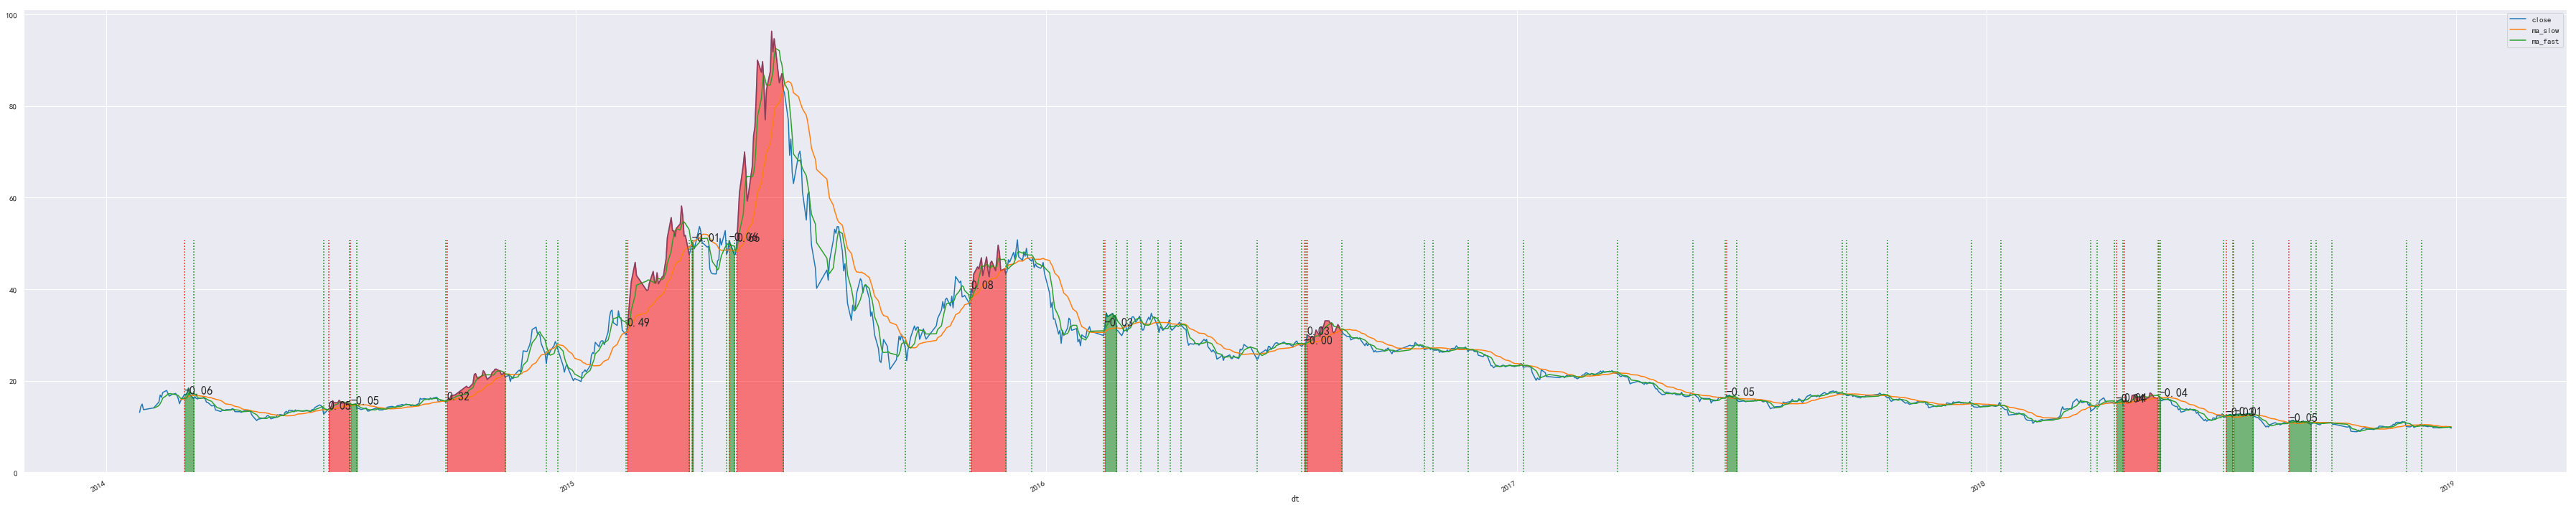

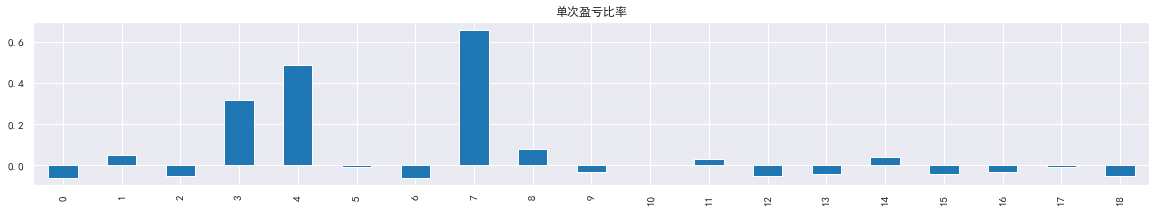

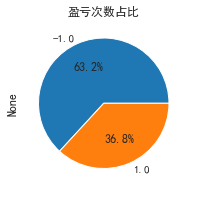

In [10]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
# simple_data[simple_data['buy']==1]
st1=simple_test(simple_data.loc['2014-01-01':'2018-12-31'],cols1=['close','ma_slow','ma_fast'])

In [12]:
st1.name="简单测试-CTA"
st1.to_frame().T.round(2)

,盈利交易平均盈利比率,最大盈利比率,亏损交易平均亏损比率,最大亏损比率,平均盈亏比率,交易次数,总天数,平均持仓天数,R(平均利润/平均损失)
简单测试-CTA,0.24,0.66,-0.04,-0.06,0.06,19.0,1198.0,11.63,3.37


# 训练回测

## 仓位控制方法

In [13]:
class Position1(abupy.AbuPositionBase):
    """1手"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
        return 100

## 回测方法

In [14]:
def backtest(buy_factors,sell_factors,symbol='300378',init_cash=10000,**kwargs):
    start = kwargs.pop('start','2014-01-01')
    end = kwargs.pop('end','2018-12-31')

    benchmark = abupy.AbuBenchmark(symbol, start, end)
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager=kwargs.pop('klmanager',KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        [symbol],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=False)
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init']=m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

## 扩展回测报告

In [22]:
def get_report(m,name=''):
    p=m.profit_series(name='回测-{}'.format(name))
    p['平均获利期望'] = m.gains_mean  #平均获利期望\n",
    p['平均亏损期望'] = m.losses_mean  #平均亏损期望\n",
    p['盈亏比'] = m.win_loss_profit_rate  #盈亏比\n",
    p['策略年化收益'] = m.algorithm_annualized_returns  #策略年化收益\n",
    p['基准年化收益'] = m.benchmark_annualized_returns  #基准年化收益\n",
    c = m.order_has_ret
    p['赢利交易平均持股天数'] = c[c.profit > 0].keep_days.values.mean()  #赢利交易平均持股天数\n",
    p['亏损交易平均持股天数'] = c[c.profit <= 0].keep_days.values.mean()  #亏损交易平均持股天数\n",
    p = gquant.pd.to_numeric(p)
    return p.to_frame().round(2).T

## 回测结果绘图

In [16]:
def plot_cum_returns(metrics):
    metrics.benchmark_cum_returns.plot()
    metrics.algorithm_cum_returns.plot()
    gquant.plt.legend(['基准收益', '策略收益'], loc='best')
    gquant.plt.title('收益对比')
    gquant.plt.show()

def plot_win_loss_pie(metrics):
    gquant.plt.pie(x=[len(metrics.ret), len(metrics.los)],
                   labels=['盈利', '亏损'],
                   colors=['#d62728', '#2ca02c'],
                   autopct='%1.2f%%')
    gquant.plt.title('盈亏次数比')
    gquant.plt.show()
    
def plot_win_loss_bar(metrics,v='profit_cg_hunder'):
    import matplotlib.ticker
    vc=gquant.np.round(metrics.act_sell[v],0).value_counts().sort_index().to_frame()
    ax=vc.plot(kind='bar',title='盈亏百分比次数')
#     gquant.plt.axvline(x=gquant.np.where(vc.index.to_numpy()==0)[0], color='#d68a27')
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    gquant.plt.show()
    
def plot_capital_blance(metrics):
    metrics.capital.capital_pd.capital_blance.plot(title='账户价值曲线')
    metrics.capital.capital_pd.cash_blance .plot(title='账户现金曲线')
    gquant.plt.xticks(rotation=70)
    gquant.plt.show()

### 买卖策略

In [17]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if today['buy']==1:
            return self.buy_tomorrow()
        return None
    
class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if today['sell']==1:
            for order in orders:
                self.sell_tomorrow(order)

In [18]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]

bt1 = backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=3304 begin work'), FloatProgress(value=0.0)))

### 结果

|          |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-CTA |    5420.13 |    14180.8 |         19 |          8 |         11 |       0.42 |               219.97 |               677.52 |              -112.79 | 1.95 |      -0.11 |        2516.46 |           0.19 |          -0.04 |     4.94 |           0.09 |          -0.05 |                  28.25 |                   6.55 |

In [30]:
# print(bt1.profit_series(name='回测-自制策略-布林带开口').to_frame().T.to_markdown())
print(get_report(bt1,'CTA').to_markdown())

|          |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-CTA |    5420.13 |    14180.8 |         19 |          8 |         11 |       0.42 |               219.97 |               677.52 |              -112.79 | 1.95 |      -0.11 |        2516.46 |           0.19 |          -0.04 |     4.94 |           0.09 |          -0.05 |                  28.25 |                   6.55 |


# 全市场测试

考虑到以`300378`测试时交易次数不足（只有19次）。所以尝试以全市场进行测试。测试时间段依旧是`2014-01-01`~`2018-12-31`。

但是交易次数依旧不足，全市场平均交易次数也只有16次左右。

In [24]:
symbol_list=QA.QA_fetch_stock_list_adv()

class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
#         import pdb
#         pdb.set_trace()
        if self._symbol.is_index():
            df=QA.QA_fetch_index_day_adv(self._symbol.symbol_code,start,end).data.copy()
        else:
            df=QA.QA_fetch_stock_day_adv(self._symbol.symbol_code,start,end).to_qfq().data.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')
        

abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

def getreport(bts):
    report=[]
    for symbol,metrics in bts.items():
        for name,m in metrics.items():
            if m is None:
                continue
            p=m.profit_series(name=name)
            p=gquant.pd.to_numeric(p)
            p['code']=symbol
            report.append(p)
    if not report:
        return gquant.pd.DataFrame({'R':[]})
    report=gquant.pd.concat(report, axis=1).T
    for col in report.columns:
        if col=='code':
            continue
        report[col]=gquant.pd.to_numeric(report[col])
    return report

In [27]:
# 存在有股票的日线数据有问题的情况下，无法正常使用
# benchmark = abupy.AbuBenchmark(start='2014-01-01', end='2018-12-31')
# capital = abupy.AbuCapital(1000000, benchmark)
# orders_pd, action_pd, _ = abupy.AbuPickTimeMaster.do_symbols_with_same_factors_process(
#                                     symbol_list.code.values, benchmark, buy_factors,sell_factors, capital,
#                                     n_process_kl=4, n_process_pick_time=4)

In [ ]:
bts={}
for symbol in tqdm_notebook(symbol_list.code):
    bts[symbol]={}
    try:
        m=backtest(buy_factors,sell_factors,symbol=symbol,start='2014-01-01',end='2018-12-31')
        if m is None:
            continue
        bts[symbol]['策略1']=m
    except:
        continue
report=getreport(bts)

In [31]:
report.describe()

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
count,3506.0000,3506.0000,3506.0000,3506.0000,3506.0000,3506.0000,3506.0000,3245.0000,3499.0000,3499.0000,3506.0000,3506.0000
mean,534.1539,9827.0989,16.5910,3.6515,12.9395,0.2186,-16.3288,146.2009,-65.3243,0.5632,-0.0728,1418.6590
std,719.1830,639.2183,7.1516,2.3333,5.8824,0.1260,64.0280,177.6751,56.8178,0.4705,0.0437,996.1716
min,0.0000,6936.9120,1.0000,0.0000,0.0000,0.0000,-861.0155,0.0667,-861.0155,0.0000,-0.3728,112.1771
25%,100.0432,9516.8443,11.0000,2.0000,9.0000,0.1364,-33.1641,46.4964,-77.9103,0.2600,-0.0905,766.6361
50%,309.4023,9766.3855,17.0000,3.0000,13.0000,0.2143,-15.1403,92.0981,-48.5513,0.5200,-0.0626,1151.2997
75%,681.1066,10049.9410,22.0000,5.0000,17.0000,0.2857,2.6938,179.4921,-32.4835,0.7700,-0.0424,1759.2365
max,10565.0620,16082.4100,39.0000,14.0000,33.0000,1.0000,936.7756,2935.1047,-3.5852,8.4200,-0.0010,9954.7489


In [28]:
report[report['交易次数']>30].describe()

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
count,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000,54.0000
mean,664.9993,9512.1937,32.7407,6.9074,25.8333,0.2110,-14.8431,87.6180,-45.6088,0.4374,-0.0988,1186.2353
std,629.6468,504.7762,1.8550,2.6154,2.9763,0.0791,15.4368,63.3249,22.9550,0.2170,0.0446,780.8837
min,26.1561,8228.6380,31.0000,2.0000,18.0000,0.0606,-55.3420,10.2935,-108.2662,0.0200,-0.1931,257.9151
25%,262.0005,9230.6802,31.0000,5.2500,24.0000,0.1613,-22.1655,41.0597,-55.8197,0.2925,-0.1171,682.8217
50%,478.6710,9502.1330,32.0000,7.0000,25.0000,0.2188,-14.9637,74.3819,-36.6110,0.4050,-0.0900,960.6907
75%,847.3496,9756.9745,33.7500,8.7500,28.0000,0.2554,-7.8403,113.3275,-29.7564,0.5775,-0.0653,1289.4414
max,2576.3893,10875.8690,39.0000,14.0000,33.0000,0.4194,25.0139,300.0385,-10.7636,0.9200,-0.0257,3362.7005
